# Project 4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/UCLA Courses/219/Project 4'

Mounted at /content/drive
/content/drive/MyDrive/UCLA Courses/219/Project 4


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from pandas.core.indexes.interval import maybe_extract_name
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from scipy.stats import linregress
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

!pip install scikit-optimize
!pip install lightgbm
from skopt import BayesSearchCV
from lightgbm import LGBMRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 3.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data = pd.read_csv('diamonds.csv').iloc[: , 1:]
data.head()

carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    330  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    327  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    328  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    337  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    338  4.34  4.35  2.75

## Question 1.1
Plot a heatmap of the Pearson correlation matrix of the dataset columns. Report which features have the highest absolute correlation with the target variable. In the context of either dataset, describe what the correlation patterns suggest.<br>
*Cut, color, and clarity features need to be quantified before plotting the heatmap. In this step, it's more convenient to encode the labels with numbers instead of one-hot encoding. Please see the below: Carat,x,y,z are features with highest absolute correlation coefficient with the price (target).*<br>
*Looking at the correlation coefficient values between features, we notice that some features are highly correlated. This can help us with dimensionality reduction where we try to find the most useful information while reducing the dimension of feature vectors. If two features are highly correlated, we can select only one of them. The other one will be redundant. For example, in the Diamonds dataset, x,y,z and carat are highly correlated. Table has a large negative correlation with cut and debth. Positive correlation means that the two feature values change in the same direction (both increase or decrease). Negative correlation means the two features change in opposite direction, when one increases, the other decreases. We want to select features that have a large absolute correlation with the price since it means that these labels affect the price more significantly.*

In [ ]:
cut_encoder = {"Fair":0, "Good":1, "Very Good":2, "Premium":3, "Ideal":4}
data["cut"] = data["cut"].replace(cut_encoder)

color_encoder = sklearn.preprocessing.LabelEncoder()
data["color"] = color_encoder.fit_transform(data["color"])

clarity_encoder = sklearn.preprocessing.LabelEncoder()
data["clarity"] = clarity_encoder.fit_transform(data["clarity"])

<AxesSubplot:>

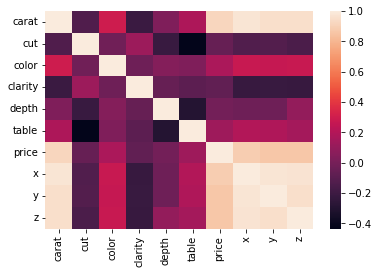

In [ ]:
sns.heatmap(data.corr())

## Question 1.2
Plot the histogram of numerical features. What preprocessing can be done if the distribution of a feature has high skewness? <br>
*We can address skewed features by transforming them and basically applying the same function to each value in the feature column. Common transformations include square root (sqrt(x)), logarithmic (log(x)), and reciprocal (1/x).*

Text(0, 0.5, 'frequency')

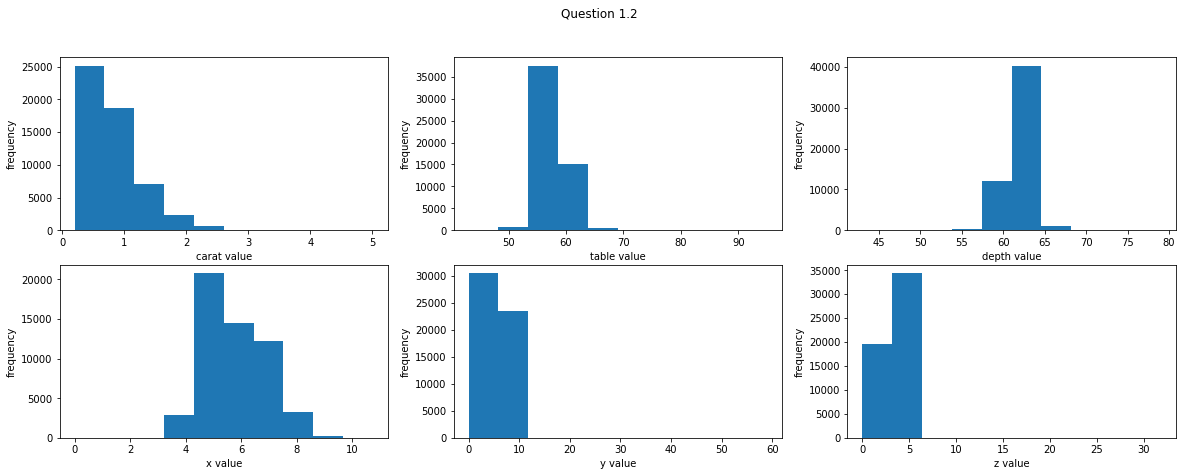

In [ ]:
#bins = np.arange(0.5,5.5,0.5)
fig, axs = plt.subplots(2,3,figsize=(20,7))
fig.suptitle('Question 1.2')

axs[0,0].hist(data['carat'])
axs[0,0].set_xlabel('carat value')
axs[0,0].set_ylabel('frequency')

axs[0,1].hist(data['table'])
axs[0,1].set_xlabel('table value')
axs[0,1].set_ylabel('frequency')

axs[0,2].hist(data['depth'])
axs[0,2].set_xlabel('depth value')
axs[0,2].set_ylabel('frequency')
"""
axs[1,1].hist(data['price'])
axs[1,1].set_xlabel('price value')
axs[1,1].set_ylabel('frequency')
"""
axs[1,0].hist(data['x'])
axs[1,0].set_xlabel('x value')
axs[1,0].set_ylabel('frequency')

axs[1,1].hist(data['y'])
axs[1,1].set_xlabel('y value')
axs[1,1].set_ylabel('frequency')

axs[1,2].hist(data['z'])
axs[1,2].set_xlabel('z value')
axs[1,2].set_ylabel('frequency')


## Question 1.3
Construct and inspect the box plot of categorical features vs target variable. What do you find? <br>
*We observe that there are many outliers for each categorical feature, meaning that there are a significant number of samples that fall out of the box plots based on a specific function of the inter-quartile range.*

<AxesSubplot:xlabel='clarity', ylabel='price'>

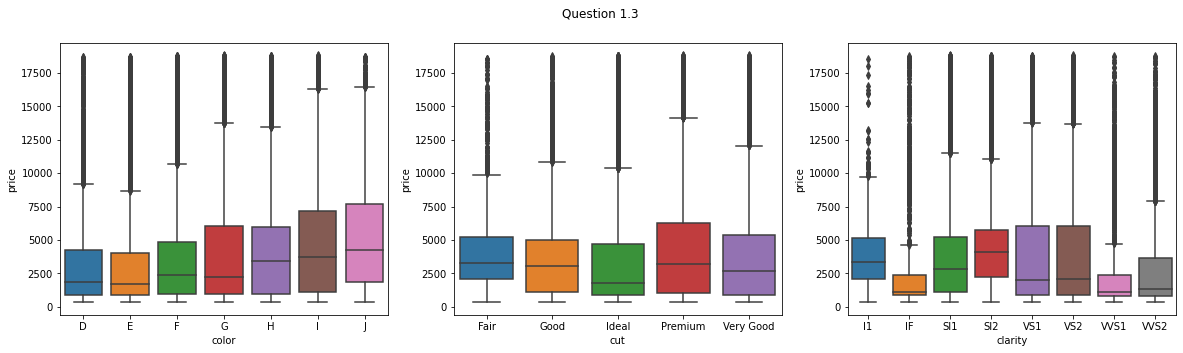

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
fig.suptitle('Question 1.3')
df = pd.read_csv('diamonds.csv').iloc[: , 1:]
sns.boxplot(data=df.sort_values("color"),x="color", y="price", ax=axs[0])
sns.boxplot(data=df.sort_values("cut"),x="cut", y="price", ax=axs[1])
sns.boxplot(data=df.sort_values("clarity"),x="clarity", y="price", ax=axs[2])

## Question 1.4
For the Diamonds dataset, plot the counts by color, cut and clarity.

<AxesSubplot:xlabel='clarity', ylabel='count'>

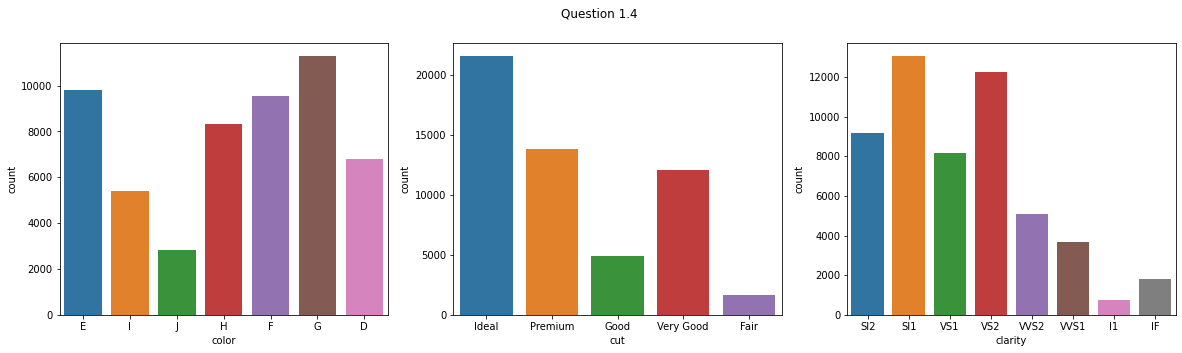

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
fig.suptitle('Question 1.4')
sns.countplot(data=df,x="color", ax=axs[0])
sns.countplot(data=df,x="cut", ax=axs[1])
sns.countplot(data=df,x="clarity", ax=axs[2])

## Question 2.1
Standardize feature columns and prepare them for training. 

In [ ]:
df = pd.read_csv('diamonds.csv').iloc[: , 1:]
features = ['carat', 'depth', 'table', 'x', 'y', 'z']
df = pd.get_dummies(df, prefix=['cut_', 'color_','clarity_'])

X_train, X_test, y_train, y_test = train_test_split(df[features], df['price'],
                                                test_size=0.1, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train, y_train)
df[features] = scaler.transform(df[features])

display(df)

carat     depth     table  price         x         y         z  \
0     -1.200857 -0.171917 -1.101919    330 -1.591291 -1.535616 -1.570754   
1     -1.243123 -1.361187  1.586388    327 -1.644853 -1.658031 -1.740645   
2     -1.200857 -3.389941  3.378592    328 -1.502020 -1.456920 -1.740645   
3     -1.074058  0.457697  0.242234    337 -1.368115 -1.317017 -1.287603   
4     -1.031792  1.087310  0.242234    338 -1.243136 -1.212090 -1.117712   
...         ...       ...       ...    ...       ...       ...       ...   
53935 -0.165338 -0.661616 -0.205817   2758  0.015577  0.020805 -0.055896   
53936 -0.165338  0.947396 -1.101919   2759 -0.037985  0.012061  0.099838   
53937 -0.207604  0.737525  1.138336   2760 -0.064766 -0.049147  0.029050   
53938  0.130524 -0.521702  0.242234   2757  0.372659  0.335586  0.283886   
53939 -0.101939  0.317782 -1.101919   2761  0.086994  0.116988  0.142310   

       cut__Fair  cut__Good  cut__Ideal  ...  color__I  color__J  clarity__I1  \
0              0          0           1  ...         0         0            0   
1              0          0           0  ...         0         0            0   
2              0          1           0  ...         0         0            0   
3              0          0           0  ...         1         0            0   
4              0          1           0  ...         0         1            0   
...          ...        ...         ...  ...       ...       ...          ...   
53935          0          0           1  ...         0         0            0   
53936          0          1           0  ...         0         0            0   
53937          0          0           0  ...         0         0            0   
53938          0          0           0  ...         0         0            0   
53939          0          0           1  ...         0         0            0   

       clarity__IF  clarity__SI1  clarity__SI2  clarity__VS1  clarity__VS2  \
0                0             0             1             0             0   
1                0             1             0             0             0   
2                0             0             0             1             0   
3                0             0             0             0             1   
4                0             0             1             0             0   
...            ...           ...           ...           ...           ...   
53935            0             1             0             0             0   
53936            0             1             0             0             0   
53937            0             1             0             0             0   
53938            0             0             1             0             0   
53939            0             0             1             0             0   

       clarity__VVS1  clarity__VVS2  
0                  0              0  
1                  0              0  
2                  0              0  
3                  0              0  
4                  0              0  
...              ...            ...  
53935              0              0  
53936              0              0  
53937              0              0  
53938              0              0  
53939              0              0  

[53940 rows x 27 columns]

## Question 2.2
Describe how this step qualitatively affects the performance of your models in terms of test RMSE. Is it true for all model types? Also list two features for either dataset that has the lowest MI w.r.t to the target. <br>
*See below for calculation of f_regression and MI for the processed numerical features:* <br>
*These two functions can help us choose the most effective features and consequently reduce the test RMSE.*

In [ ]:
features = ['carat', 'depth', 'table', 'x', 'y', 'z']#, 'cut__Fair',
       #'cut__Good', 'cut__Ideal', 'cut__Premium', 'cut__Very Good', 'color__D',
       #'color__E', 'color__F', 'color__G', 'color__H', 'color__I', 'color__J',
       #'clarity__I1', 'clarity__IF', 'clarity__SI1', 'clarity__SI2',
       #'clarity__VS1', 'clarity__VS2', 'clarity__VVS1', 'clarity__VVS2']
f_test, _ = f_regression(df[features], df['price'])
f_test,features1 = zip(*sorted(zip(f_test,features)))


mi = mutual_info_regression(df[features], df['price'])
mi, features2 = zip(*sorted(zip(mi,features)))

In [ ]:
print('two features with smallest f_regression value: ',features1[:2])
print('two features with smallest MI value: ',features2[:2])

two features with smallest f_regression value:  ('depth', 'table')
two features with smallest MI value:  ('depth', 'table')


## Question 3
Explain what OOB error and R2 score means given this link. <br>
*The **out-of-bag (OOB) error** is the average error for each calculated sample (x_i,y_i) using predictions from the trees that do not contain (x_i,y_i) in their respective bootstrap sample. By bootstrap samples we mean the training observations from which samples are bootstraped and the new tree is fit on.* <br>
*The **R-squared** explains to what extent the variance of one variable explains the variance of the second variable.*


# Linear Regression
## Question 4.1
Objective functions (based on documentation)
* Ordinary Least Squares: $\frac{1}{2N}\sum_{i=1}^N (y_i - w^T x_i)^2 = \frac{1}{2N}\|y - Xw\|_2^2 $ 
* LASSO: $\frac{1}{2N}\|y - Xw\|_2^2  + \lambda \|w\|_1$
* Ridge: $\|y - Xw\|_2^2  + \lambda \|w\|_2^2$ <br>
Explain how each regularization scheme affects the learned parameter set. <br>
 *While the ordinary least squares does not force the weights to be small or sparse, LASSO (L1) regression imposes sparsity on the learned weights, meaning that the majority of weight elements will be zero. Ridge (L2) regression on the other hand forces the learned weights to take small values. To see this, after the 10-fold cross validation step to calculate average RMSE, we use the train-test split to fit models and plot histograms of the learned weights. See below:*

In [ ]:
df.columns

Index(['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'cut__Fair',
       'cut__Good', 'cut__Ideal', 'cut__Premium', 'cut__Very Good', 'color__D',
       'color__E', 'color__F', 'color__G', 'color__H', 'color__I', 'color__J',
       'clarity__I1', 'clarity__IF', 'clarity__SI1', 'clarity__SI2',
       'clarity__VS1', 'clarity__VS2', 'clarity__VVS1', 'clarity__VVS2'],
      dtype='object')

In [ ]:
features = ['carat','clarity__I1', 'clarity__IF', 'clarity__SI1', 'clarity__SI2','clarity__VS1', 'clarity__VS2', 'clarity__VVS1', 'clarity__VVS2']


df = pd.read_csv('diamonds.csv').iloc[: , 1:]
df = pd.get_dummies(df, prefix=['cut_', 'color_','clarity_'])

#features = ['carat']

pipe_a = Pipeline([
                 ('normalize', StandardScaler()), 
                 ('estimator',linear_model.LinearRegression())
                ])
#model_a = linear_model.LinearRegression()
scores_a = cross_val_score(pipe_a, df[features], df['price'],
                           cv=10, scoring='neg_root_mean_squared_error')
print('Linear regression without regularization RMSE = ',np.mean(-scores_a))

pipe_b = Pipeline([
                 ('normalize', StandardScaler()), 
                 ('estimator',linear_model.Lasso())
                ])
#model_b = linear_model.Lasso()
scores_b = cross_val_score(pipe_b, df[features], df['price'],
                           cv=10, scoring='neg_root_mean_squared_error')
print('LASSO RMSE = ',np.mean(-scores_b))

pipe_c = Pipeline([
                 ('normalize', StandardScaler()), 
                 ('estimator',linear_model.Ridge(alpha=20))
                ])
#model_c = linear_model.Ridge(alpha=20)
scores_c = cross_val_score(pipe_c, df[features], df['price'],
                           cv=10, scoring='neg_root_mean_squared_error')
print('Ridge regression RMSE = ',np.mean(-scores_c))

Linear regression without regularization RMSE =  1267.473925036344
LASSO RMSE =  1266.828493496189
Ridge regression RMSE =  1266.9792858352032


Text(0.5, 1.0, 'Ridge')

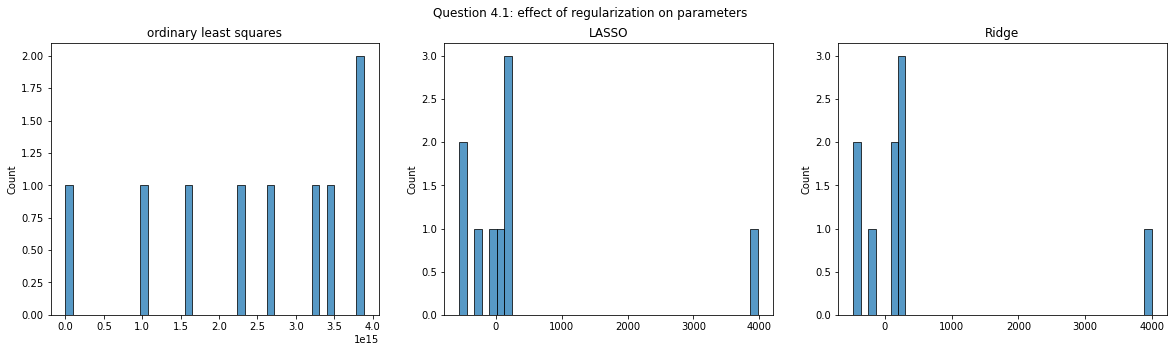

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df['price'],
                                                test_size=0.1, random_state=42)

scaler  = StandardScaler()
X_tr = scaler.fit_transform(X_train, y_train)
X_ts = scaler.transform(X_test)
model_a = linear_model.LinearRegression().fit(X_tr, y_train)
w_a = model_a.coef_

model_b = linear_model.Lasso(alpha=10).fit(X_tr, y_train)
w_b = model_b.coef_

model_c = linear_model.Ridge(alpha=20).fit(X_tr, y_train)
w_c = model_c.coef_

fig, axs = plt.subplots(1,3,figsize=(20,5))
fig.suptitle('Question 4.1: effect of regularization on parameters')
sns.histplot(data=w_a, ax=axs[0], bins=40)
sns.histplot(data=w_b, ax=axs[1], bins=40)
sns.histplot(data=w_c, ax=axs[2], bins=40)

axs[0].set_title('ordinary least squares')
axs[1].set_title('LASSO')
axs[2].set_title('Ridge')

## Question 4.2
Report your choice of the best regularization scheme along with the optimal penalty parameter and explain how you computed it. <br>
Lasso regression has the lowest RMSE =  1266.82 among the 3 models (the models perform very closely though). Since it alos ensures that the weights will be sparse by the L1 regularization, it is the best choice. I calculated the average RMSE across 10 folds of cross validation. In order to see the effect of $\alpha$ value for the L1 regularization, I varied it between 0 and 10 and noticed that the model works better for larger $\alpha$. See below:

Text(0, 0.5, 'average RMSE')

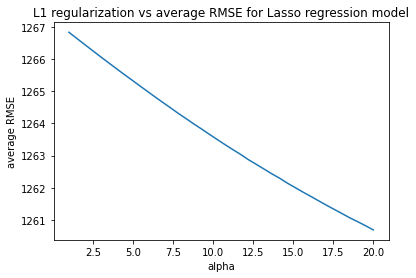

In [ ]:
rmse = []
for alpha in np.linspace(1,20,40):

  model = Pipeline([
                 ('normalize', StandardScaler()), 
                 ('estimator',linear_model.Lasso(alpha=alpha))
                ])
  scores = cross_val_score(model, df[features], df['price'],
                           cv=10, scoring='neg_root_mean_squared_error')
  rmse.append(-np.mean(scores))
plt.figure()
plt.plot(np.linspace(1,20,40),rmse)
plt.title('L1 regularization vs average RMSE for Lasso regression model')
plt.xlabel('alpha')
plt.ylabel('average RMSE')


## Question 4.3
Does feature standardization play a role in improving the model performance (in the cases with ridge regularization)? Justify your answer. <br>
*To see the effect of feature standarzation, we evaluate ridge regression with both raw and standardized features. As expected, we get better results for standardized dataset and the average RMSE is lower when we first standardize the data.*

In [ ]:
df = pd.read_csv('diamonds.csv').iloc[: , 1:]
df = pd.get_dummies(df, prefix=['cut_', 'color_','clarity_'])

#NOTE: Here I switched to using these two features to be consistent in the next steps.
features = ['carat','x']
model_raw = linear_model.Ridge(alpha=20)
scores_raw = cross_val_score(model_raw, df[features], df['price'],
                           cv=10, scoring='neg_root_mean_squared_error')
rmse_raw = np.mean(-scores_raw)

model_sd = Pipeline([
                 ('normalize', StandardScaler()), 
                 ('estimator',linear_model.Ridge(alpha=20))
                ])
scores_sd = cross_val_score(model_sd, df[features], df['price'],
                           cv=10, scoring='neg_root_mean_squared_error')
rmse_sd = np.mean(-scores_sd)

print(f'Ridge regression RMSE for raw dataset = {rmse_raw}\n Ridge regression RMSE for standardized dataset = {rmse_sd}')

Ridge regression RMSE for raw dataset = 1407.2342692731818
 Ridge regression RMSE for standardized dataset = 1398.7625809955384


## Question 4.4
Some linear regression packages return p-values for different features. What is the meaning of these p-values and how can you infer the most significant features? <br>
*The p-values in regression models can help us see if the relationships that we observe in a sample also exist in the larger population. Formally defined, the linear regression p value for each independent variable tests the null hypothesis that the variable has no correlation with the dependent variable.* <br>
*when a p value in regression is greater than the significance level, it indicates there is insufficient evidence in your sample to conclude that a non-zero correlation exists. So this means that those features are not helpful in determining the price. For example, from the heatmap we know that there is not much correlation between clarity feature and price.*

In [ ]:
slope, intercept, r, p, se = linregress(df['clarity__I1'], df['price'])
print('p value for clarity type I1 feature with price is: ',p)

p value for clarity type I1 feature with price is:  0.9529243875707012


# Polynomial Regression

## Question 5.1
What are the most salient features? Why? <br>
*Based on the heatmaps and p-values, I realized that 'carat' and 'x' are the most useful features. So for the next steps, I will use these.*
## Question 5.2
What degree of polynomial is best? How did you find the optimal degree? <br>
*For the two features we selected, based on the figure below, polynomial of degree maximum 3 is the best (has lowest average RMSE).* <br>


What does a very high-order polynomial imply about the fit on the training data? What about its performance on testing data? <br>

*Higher order polynomial might reduce training error by overfitting but will result in larger testing error. It basically is too sensitive to noisy data and outliers so it can't generalize well (high variance).*

Text(0, 0.5, 'average RMSE')

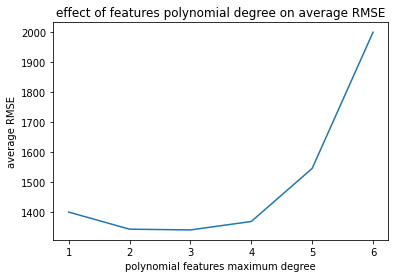

In [ ]:
features = ['carat','x']
rmse = []
for d in range(1,7):
  #poly = PolynomialFeatures(d)
  #X_new = poly.fit_transform(df[features])
  model = Pipeline([
                 ('normalize', StandardScaler()), 
                 ('feature',PolynomialFeatures(d)),
                 ('estimator',linear_model.Ridge(alpha=20))
                ])
  scores = cross_val_score(model, df[features], df['price'],
                            cv=10, scoring='neg_root_mean_squared_error')
  rmse.append(np.mean(-scores))

plt.figure()
plt.plot(range(1,7),rmse)
plt.title('effect of features polynomial degree on average RMSE')
plt.xlabel('polynomial features maximum degree')
plt.ylabel('average RMSE')


# Neural Network 

## Question 6.1
Adjust your network size (number of hidden neurons and depth), and weight decay as regularization. Find a good hyper-parameter set systematically (no more than 20 experiments in total). <br>
*In order to select the best combination of parameters, we can use gridsearchcv like previous projects. See below:*

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('diamonds.csv').iloc[: , 1:]
df = pd.get_dummies(df, prefix=['cut_', 'color_','clarity_'])

params = {'estimator__hidden_layer_sizes': [(10,20,30,20,10),(50,100,50),(20,40)], 
          'estimator__activation': ['relu'],
          'estimator__alpha' : [0.01,0.0001]
          }
#based on experiment I narrowed down the combinations of layers/neurons/weight decay for efficient running
model = Pipeline([
                 ('normalize', StandardScaler()), 
                 ('feature',PolynomialFeatures(3)),
                 ('estimator',MLPRegressor(max_iter=300))
                ])
#mlp = MLPRegressor(max_iter=500)#(hidden_layer_sizes=(20),max_iter=500,activation='relu')
grid = GridSearchCV(model, params, cv=10)

features = ['carat','x']

grid.fit(df[features],df['price']) #lbfgs

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('normalize', StandardScaler()),
                                       ('feature',
                                        PolynomialFeatures(degree=3)),
                                       ('estimator',
                                        MLPRegressor(max_iter=300))]),
             param_grid={'estimator__activation': ['relu'],
                         'estimator__alpha': [0.01, 0.0001],
                         'estimator__hidden_layer_sizes': [(10, 20, 30, 20, 10),
                                                           (50, 100, 50),
                                                           (20, 40)]})

In [ ]:
grid.best_estimator_

Pipeline(steps=[('normalize', StandardScaler()),
                ('feature', PolynomialFeatures(degree=3)),
                ('estimator',
                 MLPRegressor(hidden_layer_sizes=(20, 40), max_iter=300))])

In [ ]:
features = ['carat','x']
X_train, X_test, y_train, y_test = train_test_split(df[features], df['price'],
                                                test_size=0.1, random_state=42)

best_mlp = Pipeline([
                 ('normalize', StandardScaler()), 
                 ('feature',PolynomialFeatures(3)),
                 ('estimator',MLPRegressor(hidden_layer_sizes=(20,40), max_iter=300,alpha=0.0001))
                ])
#best_mlp = MLPRegressor(hidden_layer_sizes=(10, 20, 10), max_iter=500)
best_mlp.fit(X_train, y_train)
pred = best_mlp.predict(X_test)
mse = metrics.mean_squared_error(y_test,pred)
print('RMSE: ',np.sqrt(mse))

RMSE:  1423.8751677208913


## Question 6.2
How does the performance generally compare with linear regression? Why? <br>
*In general, I got slightly better results with linear regression. However, in some cases they were very similar. I think this could be because the MLP model might overfit the dataset especially if it has many layers or neurons.*

## Question 6.3
What activation function did you use for the output and why? You may use none. <br>
*I used 'ReLU' since we are trying to predict prices which are non-negative. Other activations such as tanh and logistic (sigmoid) limit the output to values less than 1 which is not the case here. Identity activation (no activation) does not enforce non-negativeness. As a result, ReLU seems the best choice.*

## Question 6.4
What is the risk of increasing the depth of the network too far? <br>
*Without proper normalization between layers (i.e batch normalization), we might encounter vanishing/exploding gradient problems. Also, a too complex network might cause overfitting.*

# Random Forest

## Question 7.1
Explain how these hyper-parameters affect the overall performance. Describe if and how each hyper-parameter results in a regularization effect during training. <br>
*Please see below:*
* Maximum number of feature: This is the number of features to consider each time to make the split decision and can be used to control overfitting and can be interpretted as a method of regularization. If the independent variables are highly correlated, we should decrease the maximum number of features.<br>
* depth of each tree: Adding more depth to trees makes the model more complex and it will capture more information about the data. This can cause overfitting in decision trees because the model will fit perfectly for the training data and will not be able to generalize well. Increasing the depth of tree can help with reducing training error but might cause an increase in testing error. However, too shallow trees can underfit the data and have high training accuracy. Limiting the depth of each tree can be interpretted as a regularization method since it helps prevent overfitting. <br>
* Number of trees: More trees usually increases accuracy at the cost of slower learning. So there is a tradeoff, if we want higher accuracy we should train more trees but if we want a faster training we should reduce the number of trees.


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

df = pd.read_csv('diamonds.csv').iloc[: , 1:]

df = pd.get_dummies(df, prefix=['cut_', 'color_','clarity_'])

features = ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut__Fair',
       'cut__Good', 'cut__Ideal', 'cut__Premium', 'cut__Very Good', 'color__D',
       'color__E', 'color__F', 'color__G', 'color__H', 'color__I', 'color__J',
       'clarity__I1', 'clarity__IF', 'clarity__SI1', 'clarity__SI2',
       'clarity__VS1', 'clarity__VS2', 'clarity__VVS1', 'clarity__VVS2']

pipe = Pipeline([
                 ('normalize', StandardScaler()), 
                 ('estimator',RandomForestRegressor(max_features = None, 
                                                    max_depth=4,oob_score=True,
                                                    n_estimators=200))
                ])



scores = cross_val_score(pipe, df[features],df['price'],
                         cv=10, scoring='neg_root_mean_squared_error')
print('average RMSE = ',np.mean(-scores))

average RMSE =  1475.9550487311903


## Question 7.2
How do random forests create a highly non-linear decision boundary despite the fact that all we do at each layer is apply a threshold on a feature? <br>
*What happens is that the combination of multiple thresholdings results in non-linear boundaries. Random Forests use decision boundaries of multiple decision trees. Each of these trees divide the data in multiple steps (depth of tree) using various boundaries. So the resulting model is highly non-linear.*

## Question 7.3
Randomly pick a tree in your random forest model (with maximum depth of 4) and plot its structure. Which feature is selected for branching at the root node? What can you infer about the importance of this feature as opposed to others? Do the important features correspond to what you got in part 3.3.1? <br>
*Please see below. As expected, the first feature which is "carat" was used for branching at the root. This means that "carat" is a more important feature in determining the price. This was previously implied by the heatmaps and also part 3.3.1*


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df['price'],
                                                test_size=0.1, random_state=42)

pipe.fit(X_train,y_train)

Pipeline(steps=[('normalize', StandardScaler()),
                ('estimator',
                 RandomForestRegressor(max_depth=4, max_features=None,
                                       n_estimators=200, oob_score=True))])

In [ ]:
estimator = pipe['estimator'].estimators_[3]

In [ ]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                #feature_names = df[features],
                #class_names =df['price'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## Question 7.4
Measure “Out-of-Bag Error” (OOB). Explain what OOB error and R2 score means. <br>
* *The out-of-bag (OOB) error is the average error for each calculated sample (x_i,y_i) using predictions from the trees that do not contain (x_i,y_i) in their respective bootstrap sample. By bootstrap samples we mean the training observations from which samples are bootstraped and the new tree is fit on.* <br>
* *R-squared explains to what extent the variance of one variable explains the variance of the second variable.*

In [ ]:
OOB = pipe['estimator'].oob_score_
print('OOB error: ',1-OOB)

R2 = pipe.score(X_test, y_test)
print('R^2 score: ',R2)

OOB error:  0.10118009302400888
R^2 score:  0.8985329802612089


# LightGBM, CatBoost and Bayesian Optimization

## Question 8.1
Read the documentation of LightGBM OR CatBoost and determine the important hyperparameters along with a search space for the tuning of these parameters (keep the search space small). <br>
LightGBM: <br>
* num_leaves: a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. High depth can induce over-fitting. So we should set num_leaves smaller than 2^(max_depth). Since max_depth in previous step was 4, we can for examplesearch the space [4:12].
* min_data_in_leaf:  Helps prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset. So we can search the space [100,500,1000]
* max_depth: following the last part, we will set this to [4]

## Question 8.2
Apply Bayesian optimization using skopt.BayesSearchCV from scikit-optmize to find the ideal hyperparameter combination in your search space. Report the best hyperparameter set found and the corresponding RMSE. 

In [ ]:
pipe = Pipeline([
                 ('normalize', StandardScaler()), 
                 ('estimator',LGBMRegressor())
                ])

opt = BayesSearchCV(
       pipe,
       {
        'estimator__num_leaves':[4,8,10,12],
        'estimator__max_depth':[4], 
        'estimator__min_child_samples':[100,500,1000], #same as min_data_in_leaf
        'estimator__n_estimators':[50,100]  },
     random_state=0,
     cv = 10
 )

opt.fit(df[features],df['price'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.8/dist-packa

BayesSearchCV(cv=10,
              estimator=Pipeline(steps=[('normalize', StandardScaler()),
                                        ('estimator', LGBMRegressor())]),
              random_state=0,
              search_spaces={'estimator__max_depth': [4],
                             'estimator__min_child_samples': [100, 500, 1000],
                             'estimator__n_estimators': [50, 100],
                             'estimator__num_leaves': [4, 8, 10, 12]})

In [ ]:
opt.best_estimator_

Pipeline(steps=[('normalize', StandardScaler()),
                ('estimator',
                 LGBMRegressor(max_depth=4, min_child_samples=100,
                               num_leaves=12))])

In [ ]:
pipe = Pipeline([
                 ('normalize', StandardScaler()), 
                 ('estimator',LGBMRegressor(max_depth=4, min_child_samples=100, num_leaves=12))
                ])

X_train, X_test, y_train, y_test = train_test_split(df[features], df['price'],
                                                test_size=0.1, random_state=42)

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
mse = metrics.mean_squared_error(y_test,pred)
print('RMSE: ',np.sqrt(mse))

RMSE:  665.8832715778444


## Question 8.3
Qualitatively interpret the effect of the hyperparameters using the Bayesian optimization results: Which of them helps with performance? Which helps with regularization (shrinks the generalization gap)? Which affects the fitting efficiency? <br>
* max_depth: Increasing the max_depth can improve training accuracy but might also cause overfitting (increases the generalization gap). It also increases training time (reducing fitting efficiency).
* min_data_in_leaf: Helps prevent over-fitting in a leaf-wise tree. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. For faster convergence we should increase min_data_in_leaf.
* num_leaves: increasing it can cause overfitting so worse for regularization, and also increases convergence time (reduces fitting efficiency). <br>
Based on these, we notice that there is a trade-off between performance and convergence time for min_data_in_leaf. The other two hyperparameters change chance of overfitting and convergence time in the same direction.

# Twitter Data

In [ ]:
import datetime, time
import pytz

pst_tz = pytz.timezone('America/Los_Angeles')

## Question 9.1
Report the following statistics for each hashtag, i.e. each file has: 
* Average number of tweets per hour
* Average number of followers of users posting the tweets per tweet
* Average number of retweets per tweet <br>

*Please see below*


In [ ]:
import json

def load_file(file):
    '''
    load the time, follows, and retweets
    '''
    
    result = []
    tweet_count= 0
    for item in open("./ECE219_tweet_data/" + file, 'r') :
        tweet_count=tweet_count+1
        tmp = []
        a = json.loads(item)
        citation_date = a['citation_date'] #the time a tweet is posted
        tmp.append(citation_date)
        tmp.append(datetime.datetime.fromtimestamp(citation_date, pst_tz))
        tmp.append(a['author']['followers']) #the number of followers of the person tweeting
        tmp.append(a['metrics']['citations']['total']) #number of retweets of a tweet
        
        result.append(tmp)
    
    return result, tweet_count


In [ ]:
files = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", 
        "tweets_#nfl.txt", "tweets_#patriots.txt", 
        "tweets_#sb49.txt", "tweets_#superbowl.txt"]
df = [None for i in range(len(files))]
data = [None for i in range(len(files))]
for i in range(len(files)):

  print(f'------------- information for {files[i]}------------')
  df[i], count = load_file(files[i])
  data[i] = pd.DataFrame(df[i],columns=['unix','time of tweet','follower per person','retweet per tweet'])
  total_time = (max(data[i]['unix']) - min(data[i]['unix']))/3600
  print('average number of tweets per hour: ',count/total_time)
  print('Average number of followers of users posting the tweets per tweet: ',sum(data[i]['follower per person'])/count)
  print('Average number of retweets per tweet: ',sum(data[i]['retweet per tweet'])/count)


------------- information for tweets_#gohawks.txt------------
average number of tweets per hour:  292.48785062173687
Average number of followers of users posting the tweets per tweet:  2217.9237355281984
Average number of retweets per tweet:  2.0132093991319877
------------- information for tweets_#gopatriots.txt------------
average number of tweets per hour:  40.95469800606194
Average number of followers of users posting the tweets per tweet:  1427.2526051635405
Average number of retweets per tweet:  1.4081919101697078
------------- information for tweets_#nfl.txt------------
average number of tweets per hour:  397.0213901819841
Average number of followers of users posting the tweets per tweet:  4662.37544523693
Average number of retweets per tweet:  1.5344602655543254
------------- information for tweets_#patriots.txt------------
average number of tweets per hour:  750.89426460689
Average number of followers of users posting the tweets per tweet:  3280.4635616550277
Average number of


## Question 9.2
Plot “number of tweets in hour” over time for #SuperBowl and #NFL (a bar plot with 1-hour bins).<br>
*Please see below*

In [ ]:
def plt_histogram(timestamp, title):

    hourly_tweet_dict={}
    min_time=min(timestamp)
    hourly_tweet_dict=dict.fromkeys([*range(int(((max(timestamp)-min_time)/3600)+1))],0)
    
    for i in timestamp:
      hourly_tweet_dict[int((i-min_time)/3600)]+=1

    plt.ylabel('Number of tweets')
    plt.xlabel('Hours')
    plt.title(f'Question 9.2: Number of tweets per hour for {title}')
    plt.bar(hourly_tweet_dict.keys(),hourly_tweet_dict.values(),color='purple')
    plt.show()

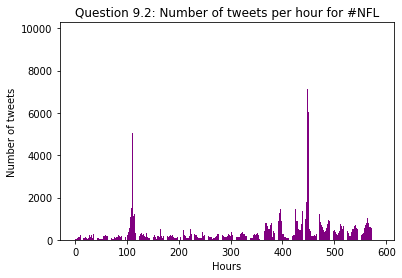

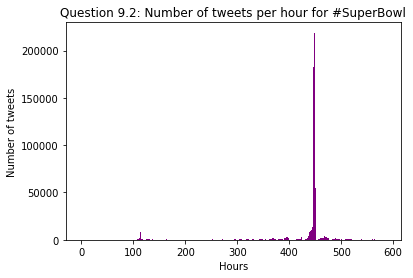

In [ ]:
plt_histogram(data[2]['unix'],'#NFL')
plt_histogram(data[5]['unix'],'#SuperBowl')

# Question 10: Prediction of hashtags given tweets
In this task, I will train a classification model that predicts a relevant hashtag given a new tweet.

## Dataset preparation

In [ ]:
import re

def load_tweets():
    '''
    load the time, follows, and retweets
    '''
    #
    df = []
    for label in ['gohawks','superbowl','sb49','patriots','nfl','gopatriots']:
      for item in open(f"./ECE219_tweet_data/tweets_#{label}.txt", 'r') :

          a = json.loads(item)
          df.append([a['tweet']['text'],label])
      

    return pd.DataFrame(df,columns=['tweet','hashtag']).sample(frac=1).reset_index(drop=True)

In [ ]:
df = load_tweets()

In [ ]:
df

tweet    hashtag
0        Who wore it better? #KatyPerry or #WillFerrell...  superbowl
1        "When you pass the ball, three things can happ...       sb49
2        Not excited for work tomorrow but this game is...  superbowl
3        Selfie station! #fun #superbowl #sunday #sb49 ...       sb49
4        I've got the @Seahawks winning #SB49! #Seahawk...       sb49
...                                                    ...        ...
2823733  I've got the @Seahawks winning #SB49! #Seahawk...       sb49
2823734  Who's ready for Sunday? #Patriots #SB49 http:/...   patriots
2823735  I've got the @Patriots winning #SB49! #Patriot...   patriots
2823736  I've got the @Seahawks winning #SB49! #Seahawk...       sb49
2823737  LO ÚLTIMO: Nueva Inglaterra resurge y gana el ...   patriots

[2823738 rows x 2 columns]

## Dataset analysis and metadata
*First, we need to check if our dataset is unbalanced. Based on the bar plot below, we need to sample equal number of samples from each hashtag to have a balanced dataset.*
## Feature engineering
*Based on the task, since we are using text data to predict hashtags, we can use a similar approach as project 1. We convert the text data into TF-IDF matrix after applying some text cleaning steps. Then we use a dimensionality reduction algorithm (here SVD since it is faster than NMF to run) to reduce the complexity.*
## Model selection
*I use Randomized Search CV to select the best combination of preprocessing and classification models. To select the parameter space I used my observations from previous projects.*
## Thorough analysis
*In order to evaluate the best model, similar to previous projects we can use accuracy, precision, recall, F1 score and ROC curves. Given that I select a balanced subset of the original dataset, the 'macro' averaging scheme is appropriate for the metrics. For ROC curve, we need to convert the labels to one-hot encodings. This is because for the classification task I decided to work with numerical labels instead of one-hot encodings but to compute the multiclass ROC metric we need labels of shape (#samples,#classes)*<br>
*For all these steps, please see the code snippets below:*


superbowl     1213813
sb49           743649
patriots       440621
nfl            233022
gohawks        169122
gopatriots      23511
Name: hashtag, dtype: int64


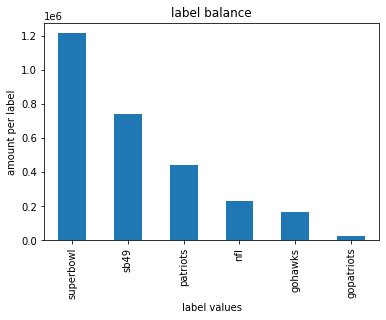

In [ ]:
cnt = df['hashtag'].value_counts()
print(cnt)
cnt.plot(kind='bar')
plt.title('label balance')
plt.xlabel('label values')
plt.ylabel('amount per label')
plt.show()

In [ ]:
new_df = df.groupby('hashtag').apply(lambda x: x.sample(n=20000)).reset_index(drop = True)
new_df['hashtag'].value_counts()

gohawks       20000
gopatriots    20000
nfl           20000
patriots      20000
sb49          20000
superbowl     20000
Name: hashtag, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_df, test_size=0.2)

X_tr = train['tweet']
X_ts = test['tweet']

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y_tr = encoder.fit_transform(train['hashtag'])
Y_ts = encoder.transform(test['hashtag'])

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
import nltk
# We need to download the following to avoid errors.
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import pos_tag
from numpy.linalg import svd
from sklearn.svm import SVC,LinearSVC
from sklearn.decomposition import NMF
from  sklearn.metrics import RocCurveDisplay, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
def evaluate_model(model, X_test, y_test, title):

  y_pred = model.predict(X_test)
  #roc = RocCurveDisplay.from_predictions(y_test,y_pred, name = title)
  #confusion = confusion_matrix(y_test,y_pred)
  acc = accuracy_score(y_test,y_pred)
  recall = recall_score(y_test,y_pred, average = 'macro')
  precision = precision_score(y_test,y_pred, average = 'macro')
  f1 = f1_score(y_test,y_pred, average = 'macro')

  print(f'Evaluation for {title} model')
  #print('confusion matrix: ')
  #print(confusion)
  print('accuracy: ',acc)
  print('recall: ',recall)
  print('precision: ',precision)
  print('F1 score: ',f1)




def remove_digit(text):
    #this function helps us remove digits 
    text = text.lower() #converts to lower case
    text = re.sub(r'\d+', '', text) #helps remove one or more (+) digits (\d) 
    return text


def lemm(text):
    stop = stopwords.words('english')
    #this will help us implement lemmatization
    text = ''.join([ch for ch in text if ch not in string.punctuation]) #removes punctuations and separates words with spaces ('')
    tokens = nltk.word_tokenize(text) #tokenizes words
    lemmatizer = WordNetLemmatizer() #we will use this to lemmatize the tokens.
    return [lemmatizer.lemmatize(token) for token in tokens if token not in stop]

def stem(text):
    stop = stopwords.words('english')
    #this will help us implement stemming (to be used in GridSearch question)
    text = ''.join([ch for ch in text if ch not in string.punctuation]) #removes punctuations and separates words with spaces ('')
    tokens = nltk.word_tokenize(text) #tokenizes words
    stemmer = PorterStemmer() #we will use this to stem the tokens.
    return [stemmer.stem(token) for token in tokens if token not in stop]


def clean_data(text):
    """
    This function is a combination of the given clean() function and remove_digit() that I defined previously.
    """
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter) 
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
      texter = ""
    texter = texter.lower() #converts to lower case
    texter = re.sub(r'\d+', '', text) #helps remove one or more (+) digits (\d) 
    return texter




class Dimension_reducer(BaseEstimator, TransformerMixin):

    def __init__(self, transformer = TruncatedSVD()):
        """
        We need to define this class to switch between dimensionality reduction algorithms
        """ 
        self.transformer = transformer

    def fit(self, X, y=None, **kwargs):
        self.transformer.fit(X, y)
        return self

    def transform(self, X, y=None, **kwargs):
        self.transformer.transform(X, y)
        return self

class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator = GaussianNB()):
        """
        We need to define this class to switch between models
        """ 
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)


params = {
    'Feature Engineering__min_df': [3,5],
    'Feature Engineering__preprocessor':[clean_data],
    #'Dimensionality Reduction__transformer':[TruncatedSVD(),NMF(init='nndsvd',tol=0.01)],
    'Dimensionality Reduction':[TruncatedSVD()],
    'Dimensionality Reduction__n_components':[5,30,80], 
    'Classifier__estimator': [LinearSVC(C=10),
                   MLPClassifier(hidden_layer_sizes=(32,64,32)),
                   LGBMClassifier()
                   ]
}


pipe = Pipeline([ 
                 ('Feature Engineering', TfidfVectorizer()),
                 ('Dimensionality Reduction',TruncatedSVD()),
                 ('Classifier',ClfSwitcher())
                ]) 



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
search = RandomizedSearchCV(pipe, params, cv=5,scoring='accuracy',
                            n_iter = 10, refit=True, verbose=3)
search.fit(X_tr, Y_tr)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END Classifier__estimator=LGBMClassifier(), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=80, Feature Engineering__min_df=5, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.865 total time= 1.1min
[CV 2/5] END Classifier__estimator=LGBMClassifier(), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=80, Feature Engineering__min_df=5, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.860 total time=  42.1s
[CV 3/5] END Classifier__estimator=LGBMClassifier(), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=80, Feature Engineering__min_df=5, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.867 total time=  45.0s
[CV 4/5] END Classifier__estimator=LGBMClassifier(), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduc

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END Classifier__estimator=MLPClassifier(hidden_layer_sizes=(32, 64, 32)), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=30, Feature Engineering__min_df=5, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.865 total time= 5.8min


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END Classifier__estimator=MLPClassifier(hidden_layer_sizes=(32, 64, 32)), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=30, Feature Engineering__min_df=5, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.857 total time= 5.1min


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END Classifier__estimator=MLPClassifier(hidden_layer_sizes=(32, 64, 32)), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=30, Feature Engineering__min_df=5, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.865 total time= 6.0min


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END Classifier__estimator=MLPClassifier(hidden_layer_sizes=(32, 64, 32)), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=30, Feature Engineering__min_df=5, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.862 total time= 5.1min


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END Classifier__estimator=MLPClassifier(hidden_layer_sizes=(32, 64, 32)), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=30, Feature Engineering__min_df=5, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.866 total time= 6.2min
[CV 1/5] END Classifier__estimator=LGBMClassifier(), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=5, Feature Engineering__min_df=5, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.767 total time=   7.0s
[CV 2/5] END Classifier__estimator=LGBMClassifier(), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=5, Feature Engineering__min_df=5, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.764 total time=   8.7s
[CV 3/5] END Classifier__estimator=LGBMClassifier(), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=5, Feature Eng

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END Classifier__estimator=MLPClassifier(hidden_layer_sizes=(32, 64, 32)), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=5, Feature Engineering__min_df=3, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.771 total time= 6.6min


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END Classifier__estimator=MLPClassifier(hidden_layer_sizes=(32, 64, 32)), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=5, Feature Engineering__min_df=3, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.773 total time= 8.2min


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END Classifier__estimator=MLPClassifier(hidden_layer_sizes=(32, 64, 32)), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=5, Feature Engineering__min_df=3, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.773 total time= 7.7min


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END Classifier__estimator=MLPClassifier(hidden_layer_sizes=(32, 64, 32)), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=5, Feature Engineering__min_df=3, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.773 total time= 7.8min


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END Classifier__estimator=MLPClassifier(hidden_layer_sizes=(32, 64, 32)), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=5, Feature Engineering__min_df=3, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.769 total time= 8.7min
[CV 1/5] END Classifier__estimator=LinearSVC(C=10), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=30, Feature Engineering__min_df=3, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.837 total time=  36.3s
[CV 2/5] END Classifier__estimator=LinearSVC(C=10), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=30, Feature Engineering__min_df=3, Feature Engineering__preprocessor=<function clean_data at 0x7f2883e31430>;, score=0.832 total time=  28.3s
[CV 3/5] END Classifier__estimator=LinearSVC(C=10), Dimensionality Reduction=TruncatedSVD(), Dimensionality Reduction__n_components=30, Feature Engi

In [ ]:
best_pipe = Pipeline([ 
                 ('Feature Engineering', TfidfVectorizer(min_df=5)),
                 ('Dimensionality Reduction',TruncatedSVD(n_components=80)),
                 ('Classifier',LGBMClassifier())
                ]) 

best_pipe.fit(X_tr, Y_tr)
evaluate_model(best_pipe, X_ts, Y_ts, 'best model LGBM Classifier')

Evaluation for best model LGBM Classifier model
accuracy:  0.8709166666666667
recall:  0.8701790869159889
precision:  0.8775415571379502
F1 score:  0.8703681760698819


labels in order are:  ['gohawks' 'gopatriots' 'nfl' 'patriots' 'sb49' 'superbowl']


<AxesSubplot:>

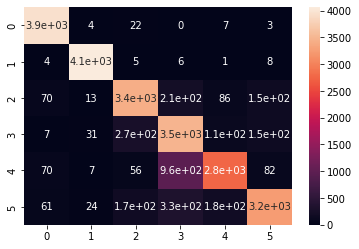

In [ ]:
print('labels in order are: ',encoder.classes_)
import seaborn as sns
cf_matrix = confusion_matrix(Y_ts,best_pipe.predict(X_ts))
sns.heatmap(cf_matrix, annot=True)

*Analyzing the confusion matrix, we note that the hashtags 'patriots' and 'sb49' have been mislabeled more significantly with each other. Searching the results of SB49 we notice that the Patriots defeated Seahawks and this could be why relevant tweets have been interpretted similarly due to the words used in each of them. In general, the metric values show that the classification task was successful.*

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
Y_ts_1h = onehot.fit_transform(Y_ts.reshape(-1,1))
pred_1h = onehot.transform(best_pipe.predict(X_ts).reshape(-1,1))

roc_auc_ovr = roc_auc_score(
    Y_ts_1h.toarray(),
    pred_1h.toarray(),
    multi_class="ovr",
    average=None,
)
for (hashtag,roc) in zip(encoder.classes_,roc_auc_ovr):
  print(f'ROC AUC for class {hashtag}: {roc}')

ROC AUC for class gohawks: 0.9901791893992803
ROC AUC for class gopatriots: 0.9950777541639834
ROC AUC for class nfl: 0.919891240659078
ROC AUC for class patriots: 0.8919760191257438
ROC AUC for class sb49: 0.8408859940872137
ROC AUC for class superbowl: 0.8950430445729505


*In order to have a sufficiently large baseline, I will implement the hashtag classification task with a number of other models and report their results as well. For efficiency, I will only use default hyperparameters of each classifier (unless the performance is very bad where I will try other values) instead of a thorough search.*

### Random Forest

Evaluation for Random Forest model
accuracy:  0.8620416666666667
recall:  0.8611949777953559
precision:  0.8709073102422852
F1 score:  0.8616619821473456
ROC AUC for class gohawks: 0.9901791893992803
ROC AUC for class gopatriots: 0.9950777541639834
ROC AUC for class nfl: 0.919891240659078
ROC AUC for class patriots: 0.8919760191257438
ROC AUC for class sb49: 0.8408859940872137
ROC AUC for class superbowl: 0.8950430445729505


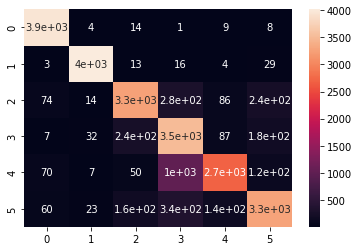

In [ ]:
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([ 
                 ('Feature Engineering', TfidfVectorizer(min_df=3)),
                 ('Dimensionality Reduction',TruncatedSVD(n_components=30)),
                 ('Classifier',RandomForestClassifier())
                ]) 

pipe.fit(X_tr, Y_tr)
evaluate_model(pipe, X_ts, Y_ts, 'Random Forest')

cf_matrix = confusion_matrix(Y_ts,pipe.predict(X_ts))
sns.heatmap(cf_matrix, annot=True)

onehot = OneHotEncoder()
Y_ts_1h = onehot.fit_transform(Y_ts.reshape(-1,1))
pred_1h = onehot.transform(best_pipe.predict(X_ts).reshape(-1,1))

roc_auc_ovr = roc_auc_score(
    Y_ts_1h.toarray(),
    pred_1h.toarray(),
    multi_class="ovr",
    average=None,
)
for (hashtag,roc) in zip(encoder.classes_,roc_auc_ovr):
  print(f'ROC AUC for class {hashtag}: {roc}')

### AdaBoost Classifier

Evaluation for AdaBoost Classifier model
accuracy:  0.823125
recall:  0.8221687519498442
precision:  0.8340579748602842
F1 score:  0.8236584611118746
ROC AUC for class gohawks: 0.9901791893992803
ROC AUC for class gopatriots: 0.9950777541639834
ROC AUC for class nfl: 0.919891240659078
ROC AUC for class patriots: 0.8919760191257438
ROC AUC for class sb49: 0.8408859940872137
ROC AUC for class superbowl: 0.8950430445729505


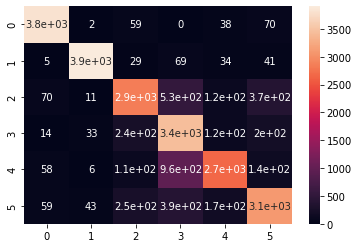

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
pipe = Pipeline([ 
                 ('Feature Engineering', TfidfVectorizer(min_df=3)),
                 ('Dimensionality Reduction',TruncatedSVD(n_components=30)),
                 ('Classifier',AdaBoostClassifier())
                ]) 

pipe.fit(X_tr, Y_tr)
evaluate_model(pipe, X_ts, Y_ts, 'AdaBoost Classifier')

cf_matrix = confusion_matrix(Y_ts,pipe.predict(X_ts))
sns.heatmap(cf_matrix, annot=True)

onehot = OneHotEncoder()
Y_ts_1h = onehot.fit_transform(Y_ts.reshape(-1,1))
pred_1h = onehot.transform(best_pipe.predict(X_ts).reshape(-1,1))

roc_auc_ovr = roc_auc_score(
    Y_ts_1h.toarray(),
    pred_1h.toarray(),
    multi_class="ovr",
    average=None,
)
for (hashtag,roc) in zip(encoder.classes_,roc_auc_ovr):
  print(f'ROC AUC for class {hashtag}: {roc}')

### Histogram-based Gradient Boosting Classification Tree

Evaluation for AdaBoost Classifier model
accuracy:  0.8675
recall:  0.8668075217861295
precision:  0.8733949715163299
F1 score:  0.8669831336786092
ROC AUC for class gohawks: 0.9901791893992803
ROC AUC for class gopatriots: 0.9950777541639834
ROC AUC for class nfl: 0.919891240659078
ROC AUC for class patriots: 0.8919760191257438
ROC AUC for class sb49: 0.8408859940872137
ROC AUC for class superbowl: 0.8950430445729505


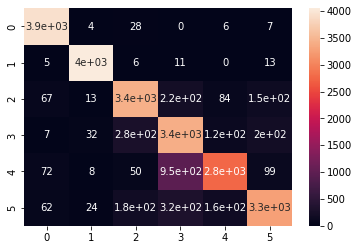

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
pipe = Pipeline([ 
                 ('Feature Engineering', TfidfVectorizer(min_df=3)),
                 ('Dimensionality Reduction',TruncatedSVD(n_components=30)),
                 ('Classifier',HistGradientBoostingClassifier())
                ]) 

pipe.fit(X_tr, Y_tr)
evaluate_model(pipe, X_ts, Y_ts, 'AdaBoost Classifier')

cf_matrix = confusion_matrix(Y_ts,pipe.predict(X_ts))
sns.heatmap(cf_matrix, annot=True)

onehot = OneHotEncoder()
Y_ts_1h = onehot.fit_transform(Y_ts.reshape(-1,1))
pred_1h = onehot.transform(best_pipe.predict(X_ts).reshape(-1,1))

roc_auc_ovr = roc_auc_score(
    Y_ts_1h.toarray(),
    pred_1h.toarray(),
    multi_class="ovr",
    average=None,
)
for (hashtag,roc) in zip(encoder.classes_,roc_auc_ovr):
  print(f'ROC AUC for class {hashtag}: {roc}')

*Baseline evaluation: The classification models perform very similarly. They can all be considered good baselines for this task. We note that some hashtags (e.g. Patriots, sb49) are more likely to be confused with each other since their contents are very close.* 